# Recreate Figure 6 from Kay, 2012 

### (MISR and MODIS low- and high-topped clouds  vs. CAM4/5)

### Add paths to run locally or off Cheyenne or Casper 


In [1]:
import sys
# Add common resources folder to path
sys.path.append('/glade/u/home/jonahshaw/Scripts/git_repos/CESM2_analysis')
sys.path.append('/glade/u/home/jonahshaw/Scripts/git_repos/CESM2_analysis/Common/')
# sys.path.append("/home/jonahks/git_repos/netcdf_analysis/Common/")

from imports import (
    pd, np, xr, mpl, plt, sns, os, 
    datetime, sys, crt, gridspec,
    ccrs, metrics, Iterable, cmaps
    )

from functions import (
    masked_average, add_weights, sp_map,
    season_mean, get_dpm, leap_year, share_ylims,
    to_png
    )

from cloud_metric import Cloud_Metric
from collections import deque
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Find the files

In [2]:
case_dir = '/glade/scratch/jonahshaw/archive/Kay_COSP_2012/'

### Load post-processed CAM4 and CAM5 files into a cloud metric

In [3]:
obsmetric = Cloud_Metric(case_dir)

fig6metric = Cloud_Metric(case_dir)
fig6metric.add_case('cam4_1deg_release_amip',label='CAM4')
fig6metric.add_case('cam5_1deg_release_amip',label='CAM5')

Loading GOCCP data...done.
Loading CALIOP SLFs...Could not load cloudtop CALIOP slfs from caliop_olimpia/ct_slf_olimpia/cloudtop_slfs.nc
Loading CERES-EBAF fluxes...done.
Loading ISCCP cloud total...done.
Loading MISR cloud histograms...done.
Loading MODIS cloud histograms...done.
Loading GOCCP data...done.
Loading CALIOP SLFs...Could not load cloudtop CALIOP slfs from caliop_olimpia/ct_slf_olimpia/cloudtop_slfs.nc
Loading CERES-EBAF fluxes...done.
Loading ISCCP cloud total...done.
Loading MISR cloud histograms...done.
Loading MODIS cloud histograms...done.
Processed timeseries directory found for cam4_1deg_release_amip. Will load data as required.
cam4_1deg_release_amip load successfully.
Processed timeseries directory found for cam5_1deg_release_amip. Will load data as required.
cam5_1deg_release_amip load successfully.


### Variable loading

In [28]:
fig6metric.load_vars('LANDFRAC');

In [4]:
obsmetric.load_vars('CLMODIS');
fig6metric.load_vars('CLMODIS');

In [5]:
obsmetric.load_vars('CLD_MISR');
fig6metric.load_vars('CLD_MISR');

### Grab case_das

In [30]:
cam4_da = fig6metric.get_case('cam4_1deg_release_amip').case_da
cam5_da = fig6metric.get_case('cam5_1deg_release_amip').case_da
modis_da = fig6metric.modis_data
misr_da = fig6metric.misr_data

### Get land fraction from CAM

In [31]:
landfrac = cam5_da['LANDFRAC'].mean('time')

### Global maps of optically thick (τ > 23) annual mean cloud fraction: (a) MISR-observed optically thick low-topped (CTH < 3 km) cloud fraction, (d) MODIS-observed optically thick high-topped (CTP < 440 mb) cloud fraction,

#### Process the MODIS histograms (slow and awkward)

In [47]:
cells5 = np.bitwise_and((cam5_da['CLMODIS'].cosp_tau_modis > 23),(cam5_da['CLMODIS'].cosp_prs < 440))
proc_modis5 = cam5_da['CLMODIS'].where(cells5).sum(['cosp_tau_modis','cosp_prs'])

In [8]:
cells4 = np.bitwise_and((cam4_da['CLMODIS'].cosp_tau_modis > 23), (cam4_da['CLMODIS'].cosp_prs < 440))
proc_modis4 = cam4_da['CLMODIS'].where(cells4).sum(['cosp_tau_modis','cosp_prs'])

In [9]:
cells_modis = np.bitwise_and((modis_da['CLMODIS'].cosp_tau_modis > 23), (modis_da['CLMODIS'].cosp_prs < 440))
proc_modis_obs = modis_da['CLMODIS'].where(cells_modis).sum(['cosp_tau_modis','cosp_prs'])

#### Process the MISR histograms (slow and awkward)

In [48]:
cells5 = np.bitwise_and((cam5_da['CLD_MISR'].cosp_tau > 23), (cam5_da['CLD_MISR'].cosp_htmisr < 3))
proc_misr5 = cam5_da['CLD_MISR'].where(cells5).sum(['cosp_tau','cosp_htmisr'])
proc_misr5 = proc_misr5.where((landfrac<0.05))

In [49]:
cells4 = np.bitwise_and((cam4_da['CLD_MISR'].cosp_tau > 23), (cam4_da['CLD_MISR'].cosp_htmisr < 3))
proc_misr4 = cam4_da['CLD_MISR'].where(cells4).sum(['cosp_tau','cosp_htmisr'])
proc_misr4 = proc_misr4.where((landfrac<0.05))

In [50]:
cells_misr = np.bitwise_and((misr_da['CLD_MISR'].cosp_tau > 23), (misr_da['CLD_MISR'].cosp_htmisr < 3))
proc_misr_obs = misr_da['CLD_MISR'].where(cells_misr).sum(['cosp_tau','cosp_htmisr'])
proc_misr_obs = proc_misr_obs.where((landfrac<0.05))

### Assign processed data to a new variable

####  MODIS

In [51]:
cam5_da['CLMODISp'] = proc_modis5
cam4_da['CLMODISp'] = proc_modis4
fig6metric.modis_data['CLMODISp'] = proc_modis_obs
obsmetric.modis_data['CLMODISp'] = proc_modis_obs

#### MISR

In [52]:
cam5_da['CLD_MISRp'] = proc_misr5
cam4_da['CLD_MISRp'] = proc_misr4
fig6metric.misr_data['CLD_MISRp'] = proc_misr_obs
obsmetric.misr_data['CLD_MISRp'] = proc_misr_obs

/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1508: UserWarning: The following kwargs were not used by contour: 'add_colorbar', 'robust'
  result = matplotlib.axes.Axes.contourf(self, *args, **kwargs)
/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1508: UserWarning: The following kwargs were not used by contour: 'add_colorbar',

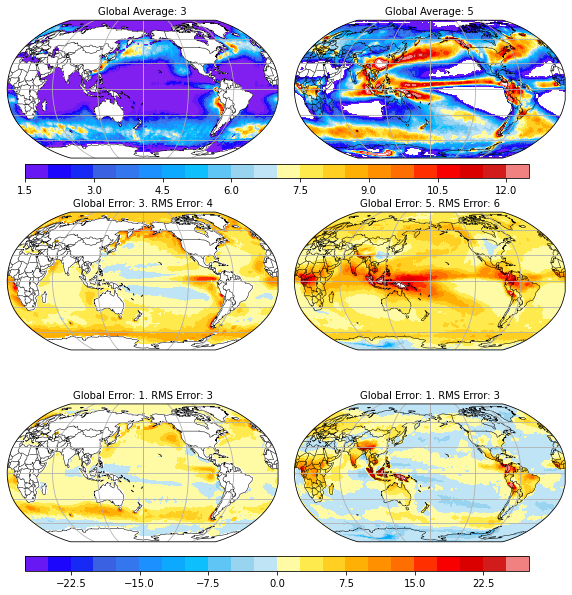

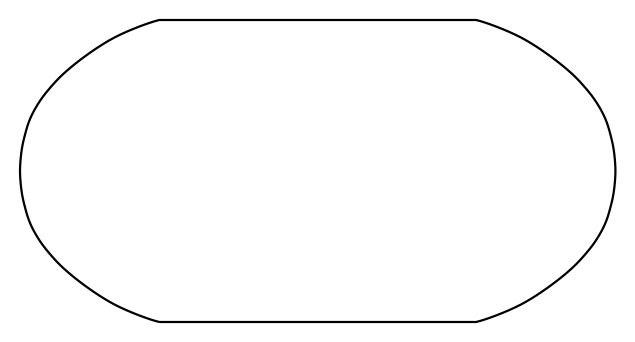

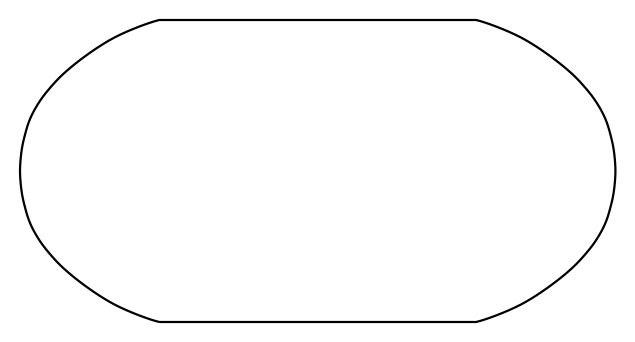

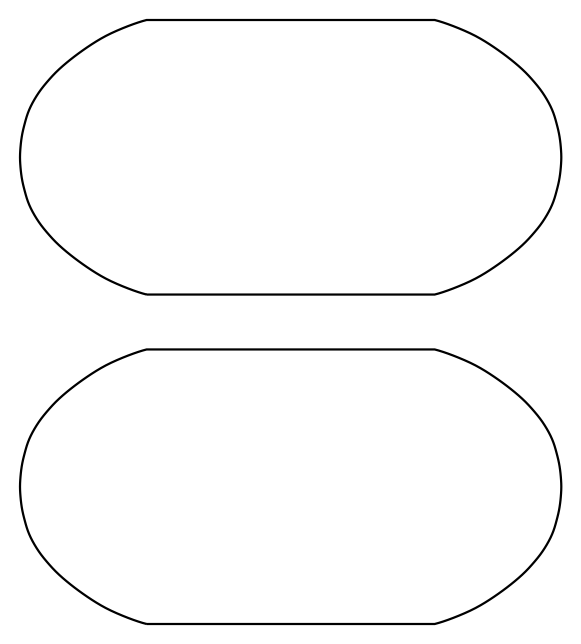

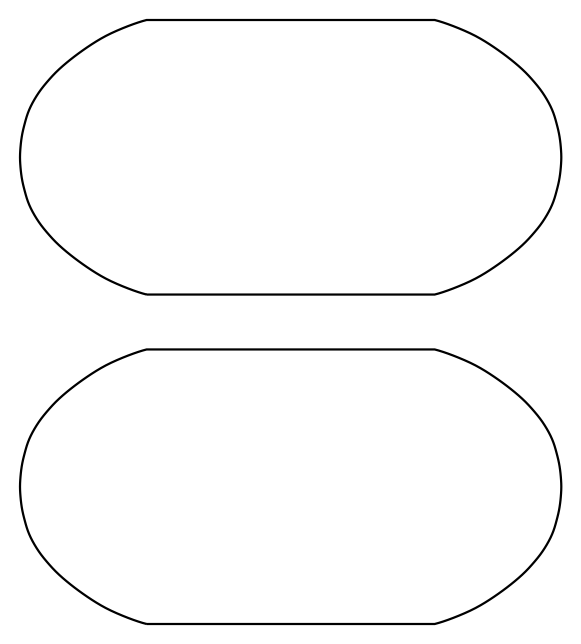

In [53]:
# fig,axs = plt.subplots(nrows=2,ncols=2,sharey='row')
fig, axs = sp_map(nrows=3, ncols=2, projection=ccrs.Robinson(central_longitude=180))#, figsize=[15,2*(len(self.cases))])

fig.set_figheight(10)
fig.set_figwidth(10)
# fig.set_dpi(200)

axs = axs.flat
fig.subplots_adjust(wspace=0.06)

misrobs = obsmetric.plot2D('CLD_MISRp',ax=[axs[0]],bias=False,contour=True,
                           levels=np.linspace(1.5,12.5,23),extend='both',
                           projection='Robinson',add_colorbar=False,label=False)

modisobs = obsmetric.plot2D('CLMODISp',ax=[axs[1]],bias=False,contour=True,
                           levels=np.linspace(1.5,12.5,23),extend='neither',
                           projection='Robinson',add_colorbar=False,label=False)

modiscam5 = fig6metric.plot2D('CLD_MISRp',ax=[axs[2],axs[4]],bias=True,contour=True,
                             levels=np.linspace(-27.5,27.5,23),extend='neither',
                             projection='Robinson',add_colorbar=False,label=False)

modiscam5 = fig6metric.plot2D('CLMODISp',ax=[axs[3],axs[5]],bias=True,contour=True,
                             levels=np.linspace(-27.5,27.5,23),extend='neither',
                             projection='Robinson',add_colorbar=False,label=False)

cbar_axh1 = fig.add_axes([0.15, 0.645, 0.70, 0.02])
cbar_axh2 = fig.add_axes([0.15, 0.10, 0.70, 0.02])

cbar1 = fig.colorbar(modisobs[1], cax=cbar_axh1,orientation='horizontal')
cbar2 = fig.colorbar(modiscam5[1], cax=cbar_axh2,orientation='horizontal')

# cbar1.set_label("%s (%s)" % (_da[var].long_name,_da[var].units))
# cbar2.set_label("%s (%s)" % (_da[var].long_name,_da[var].units))